In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("grassknoted/asl-alphabet")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'asl-alphabet' dataset.
Path to dataset files: /kaggle/input/asl-alphabet


In [ ]:
import os

os.listdir(path)
test_dir =  os.path.join(
    path,
    "asl_alphabet_test",
    "asl_alphabet_test"
)
train_dir =  os.path.join(
    path,
    "asl_alphabet_train",
    "asl_alphabet_train"
)
print(test_dir)

/kaggle/input/asl-alphabet/asl_alphabet_test/asl_alphabet_test


In [ ]:
import os
import glob
import shutil

# ====== CONFIG ======
SRC_DIR = test_dir  # dossier actuel (images à plat)
DST_DIR = os.path.join(
    "/content", # Changed path to a writable location
    "asl_alphabet_test_sorted"
)            # nouveau dossier organisé
MOVE_FILES = False  # False = copie, True = déplace
# ====================

os.makedirs(DST_DIR, exist_ok=True)

# Récupérer tous les fichiers images (jpg/png/jpeg)
patterns = ["*.jpg", "*.jpeg", "*.png", "*.JPG", "*.JPEG", "*.PNG"]
paths = []
for pat in patterns:
    paths.extend(glob.glob(os.path.join(SRC_DIR, pat)))

print("Nb fichiers trouvés:", len(paths))
if len(paths) == 0:
    raise FileNotFoundError("Aucune image trouvée. Vérifie SRC_DIR.")

def filename_to_label(filename: str) -> str:
    """
    Exemples:
    - A_test.jpg -> A
    - space_test.jpg -> space
    - nothing_test.jpg -> nothing
    - del_test.jpg -> del
    """
    base = os.path.basename(filename)
    label = base.split("_")[0]  # avant "_"

    # normaliser
    if label.lower() in ["space", "nothing", "del"]:
        return label.lower()
    else:
        return label.upper()

copied = 0
skipped = 0

for p in paths:
    label = filename_to_label(p)
    class_dir = os.path.join(DST_DIR, label)
    os.makedirs(class_dir, exist_ok=True)

    dst_path = os.path.join(class_dir, os.path.basename(p))

    # éviter d'écraser un fichier si même nom
    if os.path.exists(dst_path):
        skipped += 1
        continue

    if MOVE_FILES:
        shutil.move(p, dst_path)
    else:
        shutil.copy2(p, dst_path)

    copied += 1

print(f"✅ Terminé. Copiés/Déplacés: {copied}, Skipped (déjà existants): {skipped}")
print("Nouveau dossier organisé:", DST_DIR)


Nb fichiers trouvés: 28
✅ Terminé. Copiés/Déplacés: 28, Skipped (déjà existants): 0
Nouveau dossier organisé: /content/asl_alphabet_test_sorted


In [ ]:
import tensorflow as tf
TRAIN_DIR = train_dir
TEST_DIR  = DST_DIR

In [ ]:
IMG_SIZE=(224,224)
BATCH_SIZE=32
SEED=123

In [ ]:
train_ds=tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
val_ds=tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
class_names=train_ds.class_names
num_classes=len(class_names)
print("Class names:", class_names)
print("Number of classes:", num_classes)


Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Found 87000 files belonging to 29 classes.
Using 17400 files for validation.
Class names: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
Number of classes: 29


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 28 files belonging to 28 classes.


In [ ]:
print("Test classes:", test_ds.class_names)


Test classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'nothing', 'space']


In [ ]:
AUTOTUNE=tf.data.AUTOTUNE
train_ds=train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds=val_ds.cache().prefetch(AUTOTUNE)
test_ds=test_ds.cache().prefetch(AUTOTUNE)


In [ ]:
aug=tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.1),
])


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

base = MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)
base.trainable = False

inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = aug(inputs)
x = preprocess_input(x)
x = base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

history=model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks
)
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"✅ Test accuracy: {test_acc:.4f}")

model.save("asl_model.keras")
print("✅ Saved: asl_model.keras")


NameError: name 'callbacks' is not defined

In [ ]:
import tensorflow as tf

TRAIN_DIR = train_dir
IMG_SIZE = (160, 160)
BATCH_SIZE = 16
SEED = 123

train_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

class_names = train_ds.class_names
num_classes = len(class_names)
print("Num classes:", num_classes, class_names)

AUTOTUNE = tf.data.AUTOTUNE
# IMPORTANT: pas de cache RAM
train_ds = train_ds.shuffle(1000).prefetch(AUTOTUNE)
val_ds   = val_ds.prefetch(AUTOTUNE)

aug = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.05),
    tf.keras.layers.RandomZoom(0.10),
])

base = tf.keras.applications.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False,
    weights="imagenet"
)
base.trainable = False

inputs = tf.keras.Input(shape=IMG_SIZE + (3,))
x = aug(inputs)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)
x = base(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.25)(x)
outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"]
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("asl_best.keras", save_best_only=True),
]

model.fit(train_ds, validation_data=val_ds, epochs=10, callbacks=callbacks)


Found 87000 files belonging to 29 classes.
Using 69600 files for training.
Found 87000 files belonging to 29 classes.
Using 17400 files for validation.
Num classes: 29 ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/10
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 209s 39ms/step - accuracy: 0.6894 - loss: 1.0873 - val_accuracy: 0.9667 - val_loss: 0.1106
Epoch 2/10
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 182s 35ms/step - accuracy: 0.8826 - loss: 0.3610 - val_accuracy: 0.9791 - val_loss: 0.0691
Epoch 3/10
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 140s 27ms/step - accuracy: 0.8960 - loss: 0.3215 - val_accuracy: 0.9798 - val_loss: 0.0644
Epoch 4/10
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 127s 26ms/step - accuracy: 0.9038 - loss: 0.2974 - val_accuracy: 0.9770 - val_loss: 0.0713
Epoch 5/10
4350/4350 ━━━━━━━━━━━━━━━━━━━━ 141s 26ms/step - accuracy: 0.9030 - loss: 0.2974 - 

In [ ]:

model.save("asl_model.keras")
print("✅ Saved: asl_model.keras")

✅ Saved: asl_model.keras


Found 87000 files belonging to 29 classes.


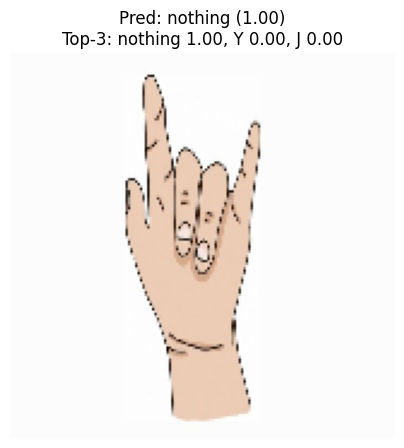

Predicted: 27 nothing


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE = (160, 160)

# Charger modèle
model = tf.keras.models.load_model("asl_best.keras")

# Charger class_names depuis le train (même IMG_SIZE)
train_ds_tmp = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=32
)
class_names = train_ds_tmp.class_names

# Image à tester
img_path = "/content/b.jpg"  # adapte le chemin si besoin (ex: /content/test.png)

img = tf.keras.utils.load_img(img_path, target_size=IMG_SIZE)
x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = tf.keras.applications.mobilenet_v2.preprocess_input(x)

probs = model.predict(x, verbose=0)[0]
pred_id = int(np.argmax(probs))

top3 = np.argsort(probs)[::-1][:3]
title = (
    f"Pred: {class_names[pred_id]} ({probs[pred_id]:.2f})\n"
    "Top-3: " + ", ".join([f"{class_names[i]} {probs[i]:.2f}" for i in top3])
)

plt.figure(figsize=(5, 5))
plt.imshow(np.array(img))
plt.axis("off")
plt.title(title)
plt.show()

print("Predicted:", pred_id, class_names[pred_id])


In [ ]:
import tensorflow as tf

IMG_SIZE = (160, 160)
BATCH_SIZE = 32
TEST_DIR = TEST_DIR  # ton test organisé en dossiers

model = tf.keras.models.load_model("asl_best.keras")

test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_ds_pp = test_ds.map(
    lambda x, y: (tf.keras.applications.mobilenet_v2.preprocess_input(tf.cast(x, tf.float32)), y)
)

test_loss, test_acc = model.evaluate(test_ds_pp, verbose=0)
print(f"✅ Test accuracy: {test_acc:.4f}")


Found 28 files belonging to 28 classes.
✅ Test accuracy: 0.0357


In [ ]:
import tensorflow as tf

IMG_SIZE = (160, 160)
BATCH_SIZE = 32

train_tmp = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
test_tmp = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

print("Train classes:", train_tmp.class_names)
print("Test  classes:", test_tmp.class_names)

print("Same set?  ", set(train_tmp.class_names) == set(test_tmp.class_names))
print("Same order?", train_tmp.class_names == test_tmp.class_names)


Found 87000 files belonging to 29 classes.
Found 28 files belonging to 28 classes.
Train classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
Test  classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'nothing', 'space']
Same set?   False
Same order? False


In [ ]:
import tensorflow as tf
import numpy as np

IMG_SIZE = (160, 160)
BATCH_SIZE = 32

TRAIN_DIR = train_dir
TEST_DIR  = DST_DIR

train_tmp = tf.keras.utils.image_dataset_from_directory(
    TRAIN_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
train_classes = train_tmp.class_names
train_to_idx = {c: i for i, c in enumerate(train_classes)}

test_tmp = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)
test_classes = test_tmp.class_names

print("Train classes:", train_classes)
print("Test  classes:", test_classes)

# 3) Charger modèle
model = tf.keras.models.load_model("asl_best.keras")

# 4) Dataset test + preprocess MobileNetV2
test_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
).map(lambda x, y: (
    tf.keras.applications.mobilenet_v2.preprocess_input(tf.cast(x, tf.float32)),
    y
))

# 5) Mapping: id_test -> id_train
test_id_to_train_id = np.array([train_to_idx[c] for c in test_classes], dtype=np.int32)

# 6) Eval manuelle (corrige le mismatch de classes)
correct = 0
total = 0

for x, y_test in test_ds:
    probs = model.predict(x, verbose=0)      # (batch, 29)
    pred_train_id = np.argmax(probs, axis=1)

    y_test = y_test.numpy()                 # (batch,) ids test (0..k-1)
    y_train_id = test_id_to_train_id[y_test]

    correct += np.sum(pred_train_id == y_train_id)
    total += len(y_test)

acc = correct / total
print(f"✅ Test accuracy (classes communes): {acc:.4f} ({correct}/{total})")


Found 87000 files belonging to 29 classes.
Found 28 files belonging to 28 classes.
Train classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'del', 'nothing', 'space']
Test  classes: ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'nothing', 'space']
Found 28 files belonging to 28 classes.
✅ Test accuracy (classes communes): 0.0357 (1/28)


In [ ]:
import os, glob
import numpy as np
import tensorflow as tf

IMG_SIZE = (160,160)
model = tf.keras.models.load_model("asl_best.keras")

train_tmp = tf.keras.utils.image_dataset_from_directory(
    train_dir, image_size=IMG_SIZE, batch_size=32
)
train_classes = train_tmp.class_names
train_to_idx = {c:i for i,c in enumerate(train_classes)}

test_tmp = tf.keras.utils.image_dataset_from_directory(
    DST_DIR, image_size=IMG_SIZE, batch_size=32, shuffle=False
)
test_classes = test_tmp.class_names
test_id_to_train_id = np.array([train_to_idx[c] for c in test_classes], dtype=np.int32)

for cls in test_classes:
    files = sorted(glob.glob(os.path.join(DST_DIR, cls, "*.*")))
    if not files:
        continue
    p = files[0]

    img = tf.keras.utils.load_img(p, target_size=IMG_SIZE)
    x = tf.keras.utils.img_to_array(img)[None, ...]
    x = tf.keras.applications.mobilenet_v2.preprocess_input(x)

    probs = model.predict(x, verbose=0)[0]
    pred_train_id = int(np.argmax(probs))
    pred_label = train_classes[pred_train_id]

    true_train_id = int(test_id_to_train_id[test_classes.index(cls)])
    true_label = train_classes[true_train_id]

    top3 = np.argsort(probs)[::-1][:3]
    top3_str = ", ".join([f"{train_classes[i]} {probs[i]:.2f}" for i in top3])

    print(f"{os.path.basename(p):20s} | True={true_label:7s}  Pred={pred_label:7s} | Top3: {top3_str}")


Found 87000 files belonging to 29 classes.
Found 28 files belonging to 28 classes.
A_test.jpg           | True=A        Pred=nothing | Top3: nothing 1.00, Y 0.00, H 0.00
B_test.jpg           | True=B        Pred=nothing | Top3: nothing 1.00, Y 0.00, J 0.00
C_test.jpg           | True=C        Pred=nothing | Top3: nothing 1.00, Y 0.00, W 0.00
D_test.jpg           | True=D        Pred=nothing | Top3: nothing 1.00, Y 0.00, W 0.00
E_test.jpg           | True=E        Pred=nothing | Top3: nothing 1.00, Y 0.00, H 0.00
F_test.jpg           | True=F        Pred=nothing | Top3: nothing 1.00, Y 0.00, W 0.00
G_test.jpg           | True=G        Pred=nothing | Top3: nothing 1.00, Y 0.00, J 0.00
H_test.jpg           | True=H        Pred=nothing | Top3: nothing 1.00, Y 0.00, H 0.00
I_test.jpg           | True=I        Pred=nothing | Top3: nothing 1.00, Y 0.00, H 0.00
J_test.jpg           | True=J        Pred=nothing | Top3: nothing 1.00, Y 0.00, H 0.00
K_test.jpg           | True=K        Pred=nothi

Found 87000 files belonging to 29 classes.


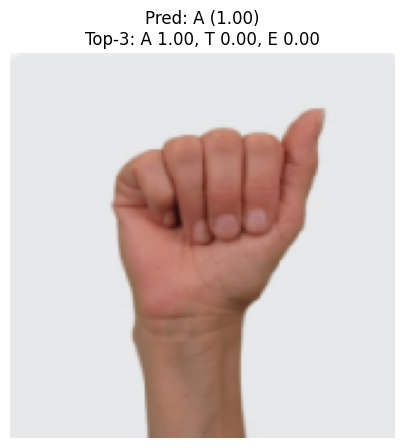

Predicted: 0 A


In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

IMG_SIZE = (160, 160)
model = tf.keras.models.load_model("asl_best.keras")

train_ds_tmp = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    batch_size=32
)
class_names = train_ds_tmp.class_names

img_path = "/content/AA.png"  # ou une image du test
img = tf.keras.utils.load_img(img_path, target_size=IMG_SIZE)
x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)  # shape (1,160,160,3)

probs = model.predict(x, verbose=0)[0]
pred_id = int(np.argmax(probs))

top3 = np.argsort(probs)[::-1][:3]
title = (
    f"Pred: {class_names[pred_id]} ({probs[pred_id]:.2f})\n"
    "Top-3: " + ", ".join([f"{class_names[i]} {probs[i]:.2f}" for i in top3])
)

plt.figure(figsize=(5,5))
plt.imshow(np.array(img))
plt.axis("off")
plt.title(title)
plt.show()

print("Predicted:", pred_id, class_names[pred_id])


In [ ]:
import tensorflow as tf

IMG_SIZE = (160, 160)
BATCH_SIZE = 32

model = tf.keras.models.load_model("asl_best.keras")

test_ds = tf.keras.utils.image_dataset_from_directory(
    DST_DIR,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"Test accuracy: {test_acc:.4f}")


Found 28 files belonging to 28 classes.
✅ Test accuracy: 0.8929


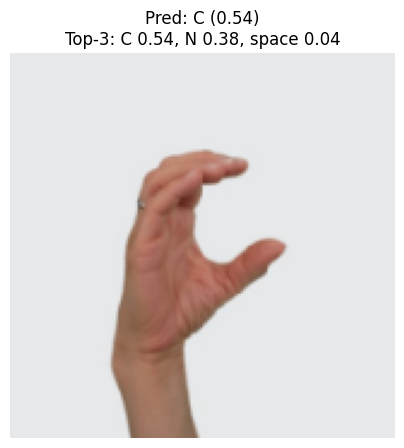

Predicted: 2 C


In [ ]:

img_path = "/content/C.png"  
img = tf.keras.utils.load_img(img_path, target_size=IMG_SIZE)
x = tf.keras.utils.img_to_array(img)
x = np.expand_dims(x, axis=0)  
probs = model.predict(x, verbose=0)[0]
pred_id = int(np.argmax(probs))

top3 = np.argsort(probs)[::-1][:3]
title = (
    f"Pred: {class_names[pred_id]} ({probs[pred_id]:.2f})\n"
    "Top-3: " + ", ".join([f"{class_names[i]} {probs[i]:.2f}" for i in top3])
)

plt.figure(figsize=(5,5))
plt.imshow(np.array(img))
plt.axis("off")
plt.title(title)
plt.show()

print("Predicted:", pred_id, class_names[pred_id])
